In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, OPTICS, Birch
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from numba import njit, prange
import itertools
import math

In [74]:
df = pd.read_csv("sample_dataset.csv")

In [75]:
df.head()

,Location ID,Latitude,Longitude,Weight
0,1,35.857621,51.536474,8
1,51,35.881941,51.366560,30
2,101,35.603620,51.264557,25
3,151,35.796481,51.437253,49
4,201,35.780196,51.465165,14


## cluster based on 25 visitors
the number of points in each cluster should be approximately equal
the distance between the points in each cluster should be as small as possible
the distance between the clusters should be as large as possible
the total money spent by each cluster should be approximately equal

In [76]:
#normalize column 4 between 0 and 1
#normalized data should not be negative
df['Weight'] = MinMaxScaler().fit_transform(df['Weight'].values.reshape(-1, 1))

In [7]:
df['Weight'].describe()

count    1250.000000
mean        0.500473
std         0.293907
min         0.000000
25%         0.244898
50%         0.510204
75%         0.755102
max         1.000000
Name: Weight, dtype: float64

In [8]:
df = df.dropna()
df_row_count = df.shape[0]
number_of_clusters = int(df_row_count / 50)
model = AgglomerativeClustering(n_clusters=number_of_clusters, affinity='euclidean', linkage='ward')
model.fit(df[['Latitude', 'Longitude']])

AgglomerativeClustering(n_clusters=25)

## plot the clusters

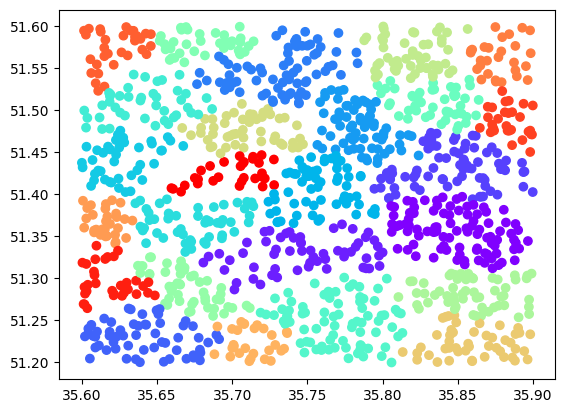

In [9]:
plt.scatter(df.iloc[:, 1], df.iloc[:, 2], c=model.labels_, cmap="rainbow")

In [10]:
model_with_weight = AgglomerativeClustering(n_clusters=25, affinity='euclidean', linkage='ward').fit(df.iloc[:, 1:4])

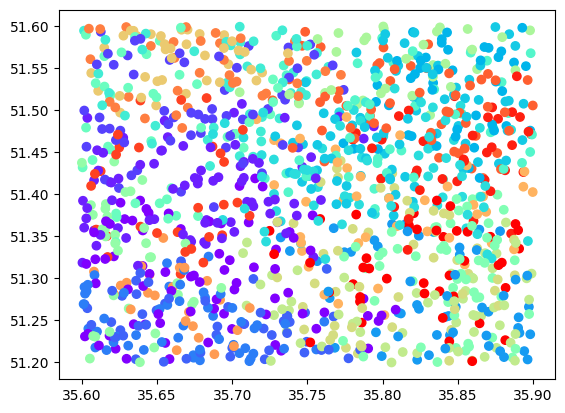

In [11]:
plt.scatter(df.iloc[:, 1], df.iloc[:, 2], c=model_with_weight.labels_, cmap="rainbow")

In [12]:
model_with_weight_km = KMeans(n_clusters=25, random_state=1).fit(df.iloc[:, 1:4])

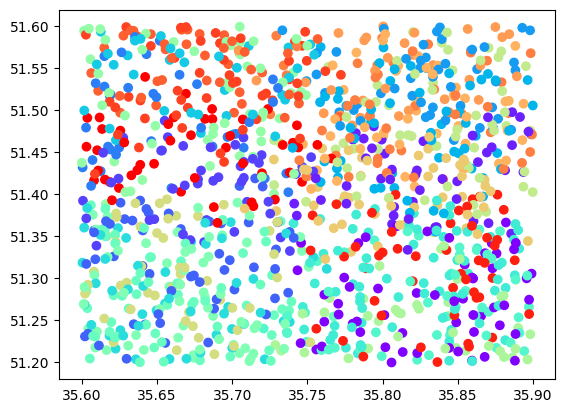

In [13]:
plt.scatter(df.iloc[:, 1], df.iloc[:, 2], c=model_with_weight_km.labels_, cmap="rainbow")

In [14]:
def cluster_data(data, min_cluster_size, max_cluster_size, cluster_method):
    cluster_sizes = range(min_cluster_size, max_cluster_size)
    models = []
    for size in cluster_sizes:
        if cluster_method == 'kmeans':
            model = KMeans(n_clusters=size, random_state=0).fit(data)
        elif cluster_method == 'agglomerative':
            model = AgglomerativeClustering(n_clusters=size, affinity='euclidean', linkage='ward').fit(data)
        models.append(model)
    return models

In [15]:
models = cluster_data(df.iloc[:, 1:4], 2, 50, 'agglomerative')

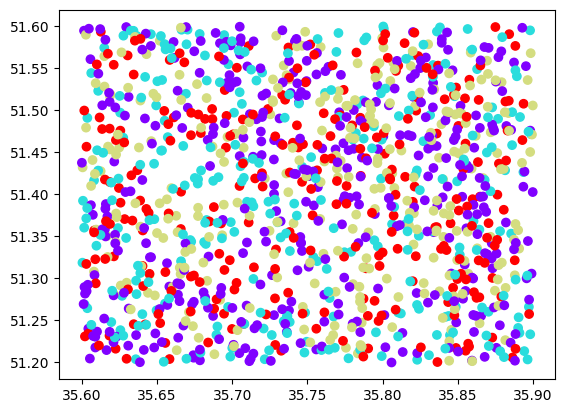

In [16]:
plt.scatter(df.iloc[:, 1], df.iloc[:, 2], c=models[2].labels_, cmap="rainbow")

In [17]:
len(models)

48

In [18]:
# the best model is the one that the weights of the clusters are the most similar and the locations are the most close to each other
def calculate_cluster_weight(model, data):
    cluster_count = len(set(model.labels_))
    cluster_weights = []
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        cluster_weight = cluster['Weight'].mean()
        cluster_weights.append(cluster_weight)
    return cluster_weights


def calculate_cluster_distance(model, data):
    cluster_count = len(set(model.labels_))
    cluster_distances = []
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        cluster_distance = cluster['Latitude'].max() - cluster['Latitude'].min() + cluster['Longitude'].max() - cluster[
            'Longitude'].min()
        cluster_distances.append(cluster_distance)
    return cluster_distances


def calculate_cluster_score(model, data):
    cluster_weights = calculate_cluster_weight(model, data)
    cluster_distances = calculate_cluster_distance(model, data)
    score = 0
    for i in range(len(cluster_weights)):
        for j in range(i + 1, len(cluster_weights)):
            score += abs(cluster_weights[i] - cluster_weights[j]) / abs(
                cluster_distances[i] - cluster_distances[j]) * 10
    return score


def calculate_best_model(models, data):
    scores = []
    for model in models:
        score = calculate_cluster_score(model, data)
        scores.append(score)
    best_model_index = scores.index(max(scores))
    return models[best_model_index]


best_model = calculate_best_model(models, df.iloc[:, 1:4])

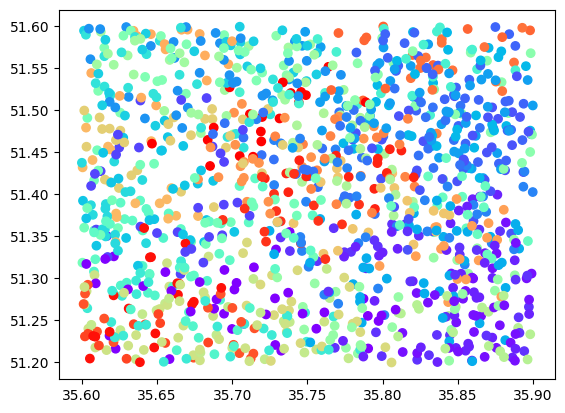

In [19]:
plt.scatter(df.iloc[:, 1], df.iloc[:, 2], c=best_model.labels_, cmap="rainbow")

<BarContainer object of 47 artists>

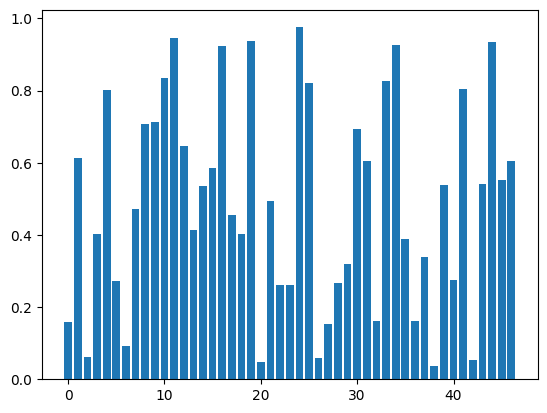

In [20]:
#bar plot of the weights of each cluster
cluster_weights = calculate_cluster_weight(best_model, df.iloc[:, 1:4])
plt.bar(range(len(cluster_weights)), cluster_weights)

In [21]:
# number of locations in each cluster
def calculate_cluster_size(model, data):
    cluster_count = len(set(model.labels_))
    cluster_sizes = []
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        cluster_size = cluster.shape[0]
        cluster_sizes.append(cluster_size)
    return cluster_sizes


# calculate_cluster_size(best_model, df.iloc[:, 1:4])
calculate_cluster_size(model_with_weight_km, df.iloc[:, 1:4])

[56,
 47,
 46,
 53,
 37,
 51,
 59,
 35,
 49,
 76,
 50,
 61,
 61,
 56,
 39,
 63,
 48,
 52,
 46,
 33,
 49,
 41,
 47,
 48,
 47]

<BarContainer object of 47 artists>

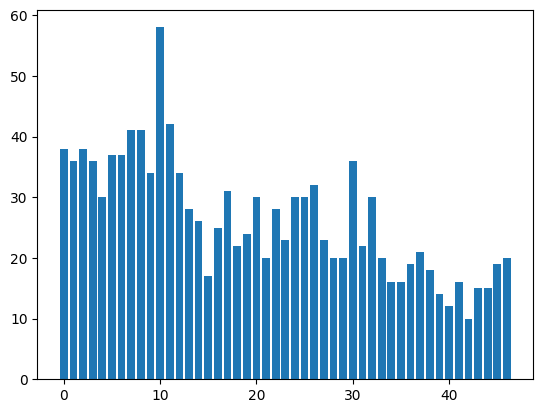

In [22]:
#bar plot of the number of locations in each cluster
cluster_sizes = calculate_cluster_size(best_model, df.iloc[:, 1:4])

plt.bar(range(len(cluster_sizes)), cluster_sizes)


## calculate shortest path between all locations in a cluster based on their coordinates
### (traveling salesman problem)


In [145]:
def distance_between_points(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    radius = 6371  # km

    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    sin_dlat = np.sin(dlat / 2)
    sin_dlon = np.sin(dlon / 2)
    cos_lat1 = np.cos(np.radians(lat1))
    cos_lat2 = np.cos(np.radians(lat2))

    a = sin_dlat * sin_dlat + cos_lat1 * cos_lat2 * sin_dlon * sin_dlon
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    d = radius * c

    return d


In [146]:
def calculate_shortest_path(locations):
    shortest_distance = math.inf
    shortest_path = None
    for path in itertools.permutations(locations):
        distance = 0
        for i in range(len(path) - 1):
            distance += distance_between_points(path[i], path[i + 1])
            if distance > shortest_distance:
                break  # Exit early if the distance exceeds the current shortest distance
        if distance < shortest_distance:
            shortest_distance = distance
            shortest_path = path
    return shortest_path, shortest_distance


In [99]:
# calculate_shortest_path([(35.6, 51.2), (35.7, 51.3), (35.8, 51.4), (35.9, 51.5)])
calculate_shortest_path([[35.655492, 51.223262],
                         [35.683981, 51.223777],
                         [35.642096, 51.245276],
                         [35.652076, 51.246849],
                         [35.602044, 51.231012],
                         [35.604192, 51.234337],
                         [35.634498, 51.245595]
                         ])

(([35.683981, 51.223777],
  [35.655492, 51.223262],
  [35.652076, 51.246849],
  [35.642096, 51.245276],
  [35.634498, 51.245595],
  [35.604192, 51.234337],
  [35.602044, 51.231012]),
 11.201146890610607)

In [147]:
#print all the locations in each cluster
def print_cluster_locations(model, data):
    cluster_count = len(set(model.labels_))
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        print(cluster)


def return_locations_in_target_cluster(model, data, target_cluster):
    cluster_count = len(set(model.labels_))
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        if i == target_cluster:
            return cluster

In [148]:
def return_locations_list_in_target_cluster(model, data, target_cluster):
    # return [[lat, lon], [lat, lon], ...]
    cluster_count = len(set(model.labels_))
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        if i == target_cluster:
            return cluster[['Latitude', 'Longitude']].values.tolist()

In [149]:
import math
import numpy as np


def haversine_distance(coord1, coord2):
    """
    Calculate the Haversine distance (in meters) between two sets of latitude and longitude coordinates.
    """
    # Earth radius in meters
    earth_radius = 6371000

    # Convert latitude and longitude to radians
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    lat1_rad = lat1 * (3.141592653589793 / 180)
    lon1_rad = lon1 * (3.141592653589793 / 180)
    lat2_rad = lat2 * (3.141592653589793 / 180)
    lon2_rad = lon2 * (3.141592653589793 / 180)

    # Haversine formula
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad
    a = (pow(math.sin(d_lat / 2), 2) +
         math.cos(lat1_rad) * math.cos(lat2_rad) * pow(math.sin(d_lon / 2), 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = earth_radius * c

    return distance


def nearest_neighbor_algorithm(start, locations):
    """
    Calculate the optimized path from the start point to the end point using latitude and longitude coordinates.

    Parameters:
    start (tuple): Latitude and longitude of the start point.
    locations (list): List of latitude and longitude coordinates for all points.

    Returns:
    list: The optimized path as a list of latitude and longitude coordinates.
    """
    # Create a copy of the list of locations to keep track of visited nodes
    unvisited = list(locations)
    path = [start]

    # Find the nearest neighbor for each point and add it to the path
    while unvisited:
        current = path[-1]
        nearest_dist = float('inf')
        nearest_neighbor = None

        for neighbor in unvisited:
            dist = haversine_distance(current, neighbor)
            if dist < nearest_dist:
                nearest_dist = dist
                nearest_neighbor = neighbor

        path.append(nearest_neighbor)
        unvisited.remove(nearest_neighbor)

    return path



In [150]:
locations_list_in_cluster_42 = return_locations_list_in_target_cluster(best_model, df.iloc[:, 1:4], 42)
optimized_path = nearest_neighbor_algorithm(locations_list_in_cluster_42[0], locations_list_in_cluster_42)
optimized_path

[[35.655492, 51.223262],
 [35.655492, 51.223262],
 [35.652076, 51.246849],
 [35.650867, 51.257559],
 [35.642096, 51.245276],
 [35.634498, 51.245595],
 [35.611353, 51.22022],
 [35.602044, 51.231012],
 [35.604192, 51.234337],
 [35.629727, 51.204423],
 [35.683981, 51.223777]]

In [151]:
lats, lons = zip(*optimized_path)

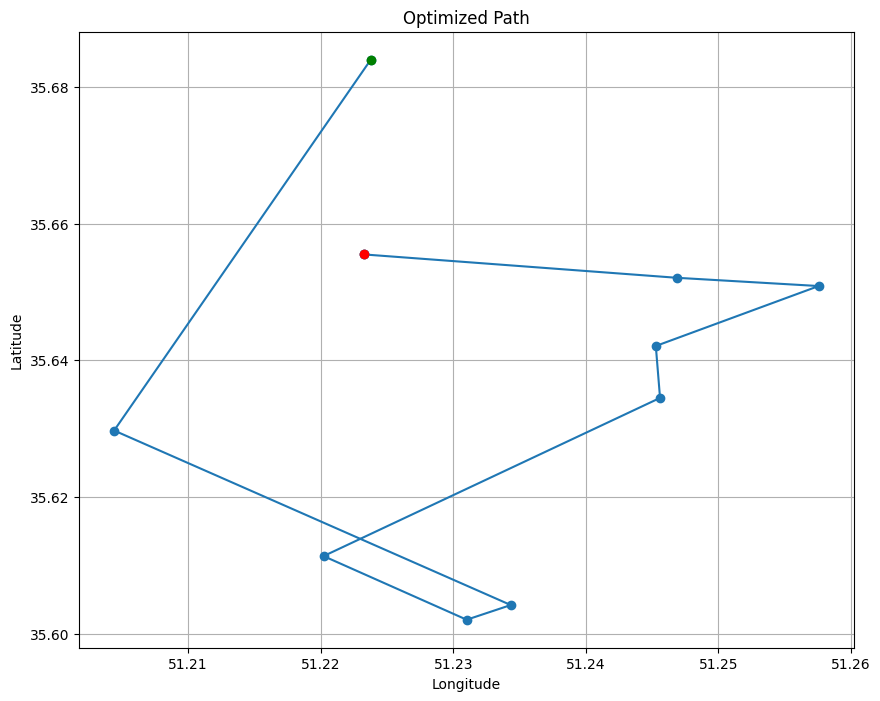

In [152]:
plt.figure(figsize=(10, 8))
plt.plot(lons, lats, marker='o', linestyle='-')
plt.plot(lons[0], lats[0], marker='o', color='red')  # Starting point
plt.plot(lons[-1], lats[-1], marker='o', color='green')  # Ending point
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Optimized Path")
plt.grid()
plt.show()

In [153]:
import itertools
import math


def haversine_distance(coord1, coord2):
    """
    Calculate the Haversine distance (in meters) between two sets of latitude and longitude coordinates.
    """
    # Earth radius in meters
    earth_radius = 6371000

    # Convert latitude and longitude to radians
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    lat1_rad = lat1 * (3.141592653589793 / 180)
    lon1_rad = lon1 * (3.141592653589793 / 180)
    lat2_rad = lat2 * (3.141592653589793 / 180)
    lon2_rad = lon2 * (3.141592653589793 / 180)

    # Haversine formula
    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad
    a = (pow(math.sin(d_lat / 2), 2) +
         math.cos(lat1_rad) * math.cos(lat2_rad) * pow(math.sin(d_lon / 2), 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = earth_radius * c

    return distance


def held_karp_algorithm(start, locations):
    """
    Calculate the most optimized path from the start point to the end point using latitude and longitude coordinates.

    Parameters:
    start (tuple): Latitude and longitude of the start point.
    locations (list): List of latitude and longitude coordinates for all points.

    Returns:
    list: The optimized path as a list of latitude and longitude coordinates.
    """
    num_points = len(locations)
    all_points = [start] + locations

    # Initialize the memoization table for dynamic programming
    memo = {}

    # Helper function for memoization
    def dp_mask(mask, pos):
        if mask == (1 << num_points) - 1:
            return haversine_distance(all_points[pos], start)

        if (mask, pos) in memo:
            return memo[(mask, pos)]

        min_distance = float('inf')

        for next_pos in range(1, num_points + 1):
            if not (mask & (1 << next_pos)):
                new_mask = mask | (1 << next_pos)
                distance = haversine_distance(all_points[pos], all_points[next_pos]) + dp_mask(new_mask, next_pos)
                min_distance = min(min_distance, distance)

        memo[(mask, pos)] = min_distance
        return min_distance

    # Calculate the optimal distance
    optimal_distance = dp_mask(1, 0)

    # Reconstruct the path based on the memoization table
    path = [start]
    mask = 1

    for i in range(1, num_points + 1):
        for next_pos in range(1, num_points + 1):
            if not (mask & (1 << next_pos)):
                if dp_mask(mask, 0) == haversine_distance(all_points[0], all_points[next_pos]) + dp_mask(
                        mask | (1 << next_pos), next_pos):
                    path.append(all_points[next_pos])
                    mask |= (1 << next_pos)
                    break

    return path, optimal_distance


# Example usage:
data = [
    [35.683981, 51.223777],
    [35.642096, 51.245276],
    [35.652076, 51.246849],
    [35.602044, 51.231012],
    [35.604192, 51.234337],
    [35.634498, 51.245595]
]

start_point = (35.683981, 51.223777)  # Latitude and longitude of the starting point

optimized_path, optimal_distance = held_karp_algorithm(start_point, data)
print("Optimized path:", optimized_path)
print("Optimal distance:", optimal_distance)


Optimized path: [(35.683981, 51.223777), [35.683981, 51.223777], [35.652076, 51.246849], [35.642096, 51.245276], [35.602044, 51.231012], [35.604192, 51.234337]]
Optimal distance: 19080.903311076603


In [156]:

optimized_path, optimal_distance = held_karp_algorithm(locations_list_in_cluster_42[0], locations_list_in_cluster_42)
print("Optimized path:", optimized_path)
print("Optimal distance:", optimal_distance)

NameError: name 'locations_list_in_cluster_43' is not defined

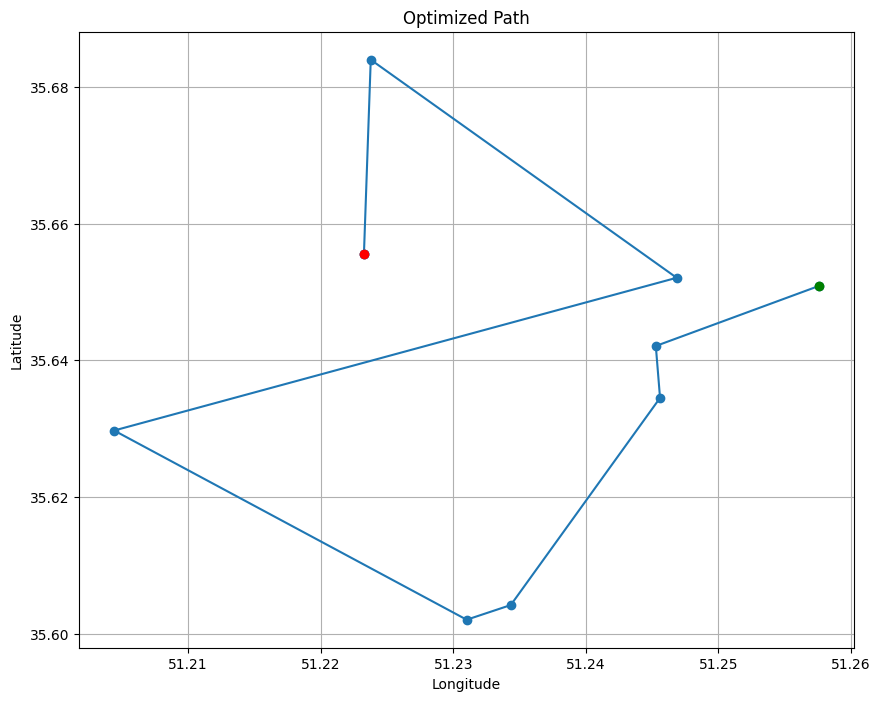

In [155]:
lats, lons = zip(*optimized_path)
plt.figure(figsize=(10, 8))
plt.plot(lons, lats, marker='o', linestyle='-')
plt.plot(lons[0], lats[0], marker='o', color='red')  # Starting point
plt.plot(lons[-1], lats[-1], marker='o', color='green')  # Ending point
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Optimized Path")
plt.grid()
plt.show()

In [157]:
test = [[1, 2, 3, 4], [1, 2, 3, 4]]

for val, j in enumerate(test):
    print(val, j)

0 [1, 2, 3, 4]
1 [1, 2, 3, 4]


Evaluate model by real data

In [69]:
df2 = pd.read_excel('CargoSample.xlsx')
df2 = df2.loc[df2['CargoDate'] == '2023-07-02']
df2 = df2.dropna()
df2 = df2.sort_values('Cargo_ID')
a = -1
b = 0
df2 = df2[df2['LatitudePoint'] > 0]
for ind, val in enumerate(list(df2['Cargo_ID'].values)):
    if val != a:
        a = val
        b += 1
        df2 = df2.replace([val], b)
df2

,Cargo_ID,DepartmentInfo_ID,CargoDate,SaleInvoice_ID,MainAccount_ID,LatitudePoint,LongitudePoint
9762,1,8,2023-07-02,1402088558,347926,32.677001,51.529933
18593,1,8,2023-07-02,1402088649,371004,32.660301,51.552088
10383,1,8,2023-07-02,1402088411,140100287,32.680437,51.549944
16510,1,8,2023-07-02,1402088544,348242,32.693774,51.534673
18266,1,8,2023-07-02,1402088667,369714,32.632840,51.370313
...,...,...,...,...,...,...,...
16103,100,51,2023-07-02,14025125868,342867,36.206077,49.192184
18015,100,51,2023-07-02,14025126580,368598,36.148680,49.224966
16102,100,51,2023-07-02,14025125974,342865,36.251169,49.128740
16121,100,51,2023-07-02,14025126049,342891,36.203114,49.190178


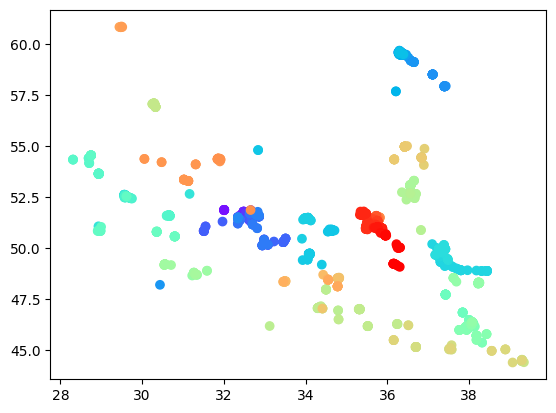

In [70]:
plt.scatter(df2.iloc[:, 5], df2.iloc[:, 6], c=df2.iloc[:, 0], cmap="rainbow")

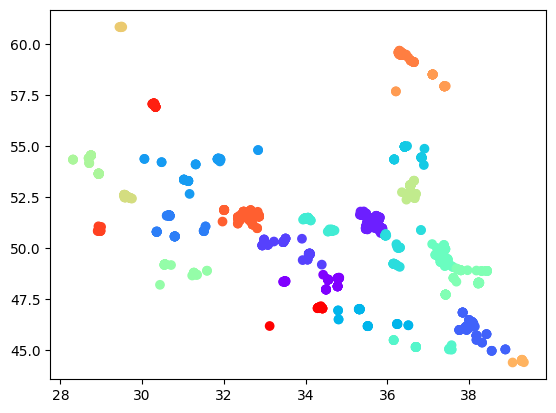

In [72]:
model.fit(df2[['LatitudePoint', 'LongitudePoint']])
plt.scatter(df2.iloc[:, 5], df2.iloc[:, 6], c=model.labels_, cmap="rainbow")